# IMPORTS

## Libraries

In [1]:
import warnings

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as ss

from IPython.display      import Image
from IPython.core.display import HTML


warnings.filterwarnings("ignore")

## Load Dataset

In [2]:
dfRaw = pd.read_feather('00-Data/FeatherData/df02.feather')

In [3]:
dfRaw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,Origin
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,True,True,101348.88,True,Adult,Latin
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,False,True,112542.58,False,Adult,Latin
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,True,False,113931.57,True,Adult,Latin
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,False,False,93826.63,False,Adult,Latin
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,True,True,79084.10,False,Adult,Latin


## Helper Functions

#### Jupyter Settings

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [5]:
jupyter_settings()  

Populating the interactive namespace from numpy and matplotlib


#### Functions

In [6]:
def cramerV(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

## Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Women usually buy more products
> - H03 - Younger clients are less loyal and more likely to leave a bank
> - H04 - Clients with higher estimated wages have higher Churn Rate
> - H05 - Countries of Latin origin have higher number of churn
> - H06 - Active members have less churn
> - H07 - Along the years Churn tends to be lower
> - H08 - Customers with Credit Cards tend to stay at the bank
> - H09 - Customers with higher balance remain at the bank

# EXPLORATORY DATA ANALYSIS

In [8]:
df04 = dfRaw.copy()

## Response Variable

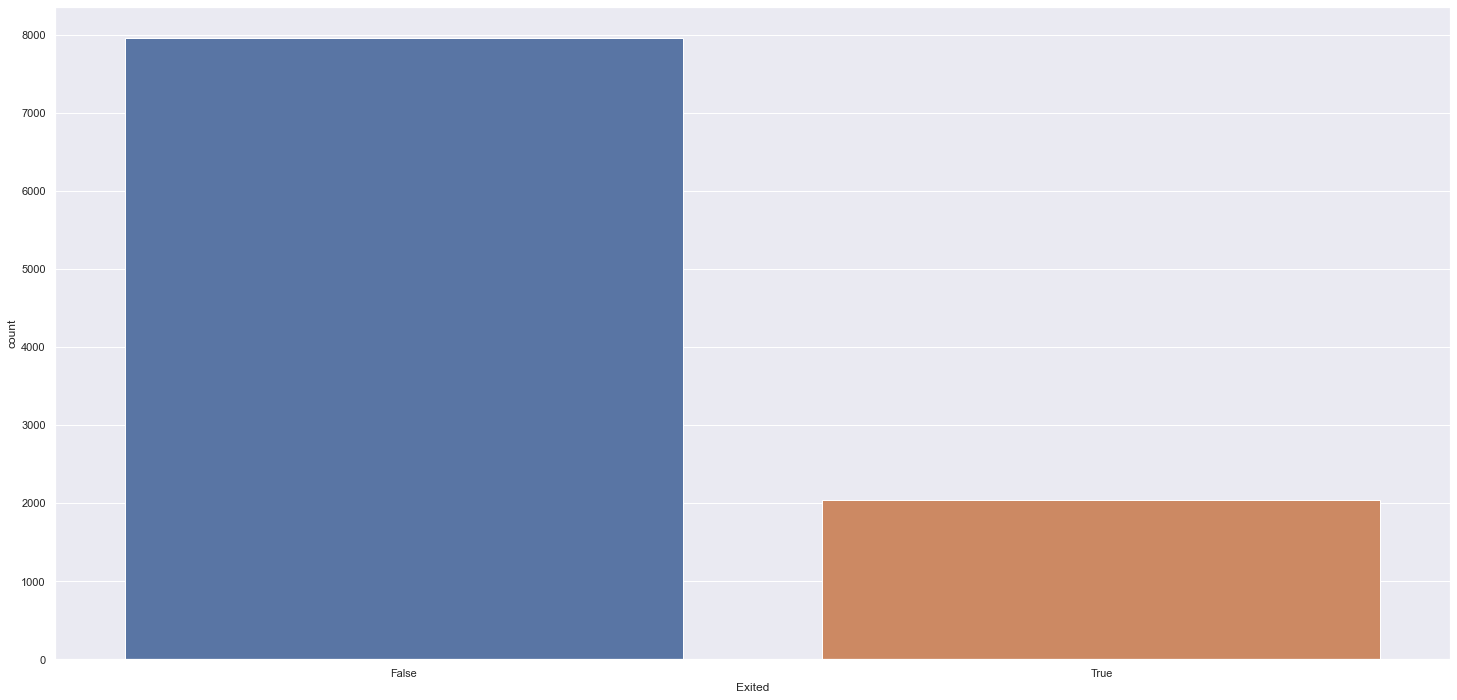

In [9]:
sns.countplot(x='Exited', data=df04);

---
> - Conclusion: **Disbalanced Dataset** 
---

## Univariate Analysis

### Numerical Attributes

In [10]:
# Numerical Attributes
numAttributes = df04.select_dtypes(include=['int64', 'float64'])
NotNumerial = ['RowNumber', 'CustomerId']
numAttributes = numAttributes[numAttributes.columns[~numAttributes.columns.isin(NotNumerial)]]

#Categorical Attributes
catAttributes = df04.select_dtypes(include=['category'])

#Boolean Attributes
boolAttributes = df04.select_dtypes(include=['bool'])

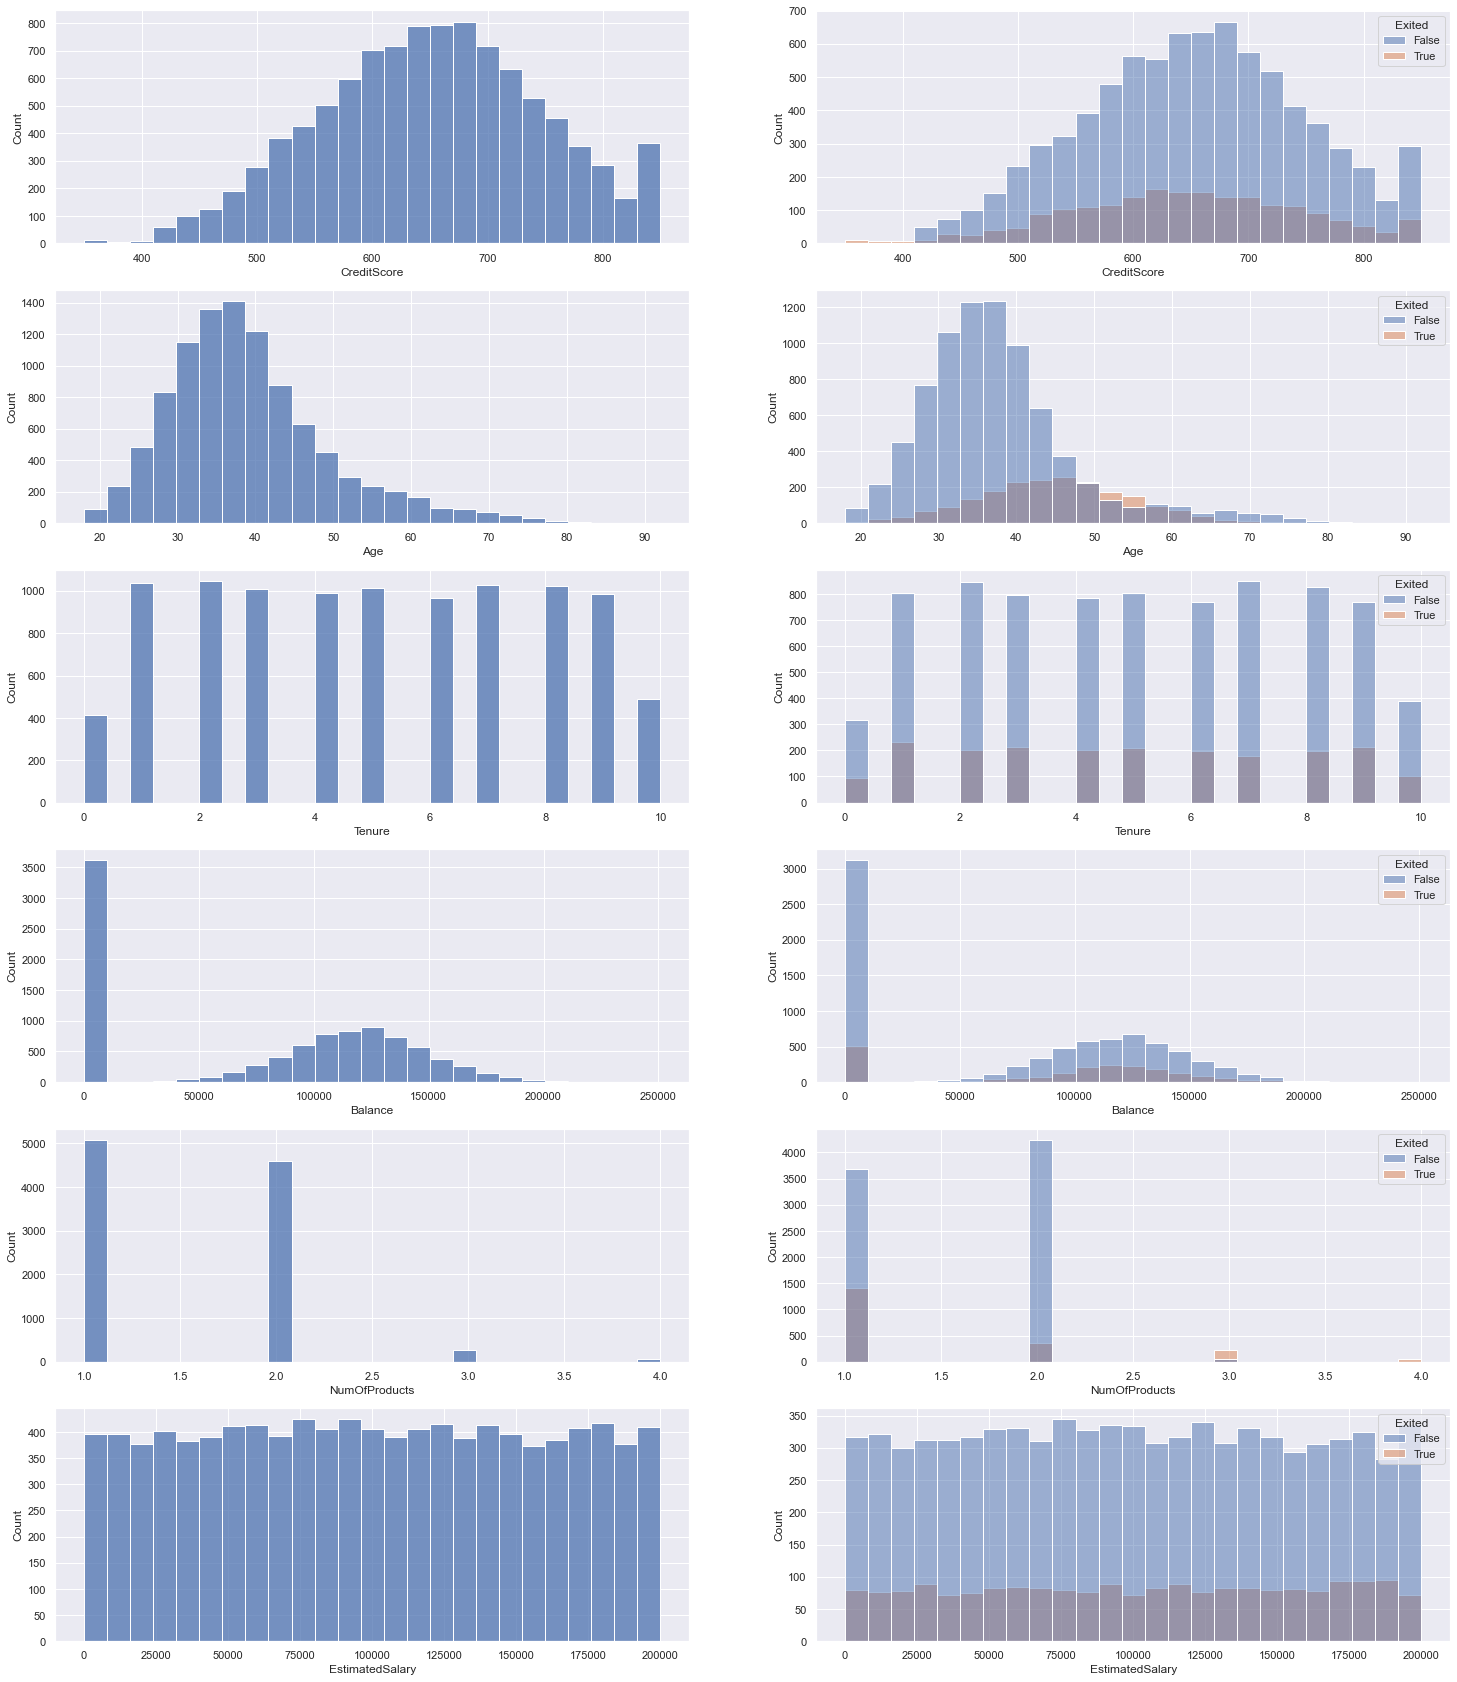

In [12]:
count = 1
attributesToInspect = numAttributes.columns
rows= len(attributesToInspect)
plt.figure(figsize=(25,5*rows))
for i in attributesToInspect:
    plt.subplot(rows, 2, count)
    sns.histplot(x=i, bins=25, data=df04)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.histplot(x=i, bins=25, hue='Exited', data=df04)
    count += 1
plt.show()

### Categorical Attributes

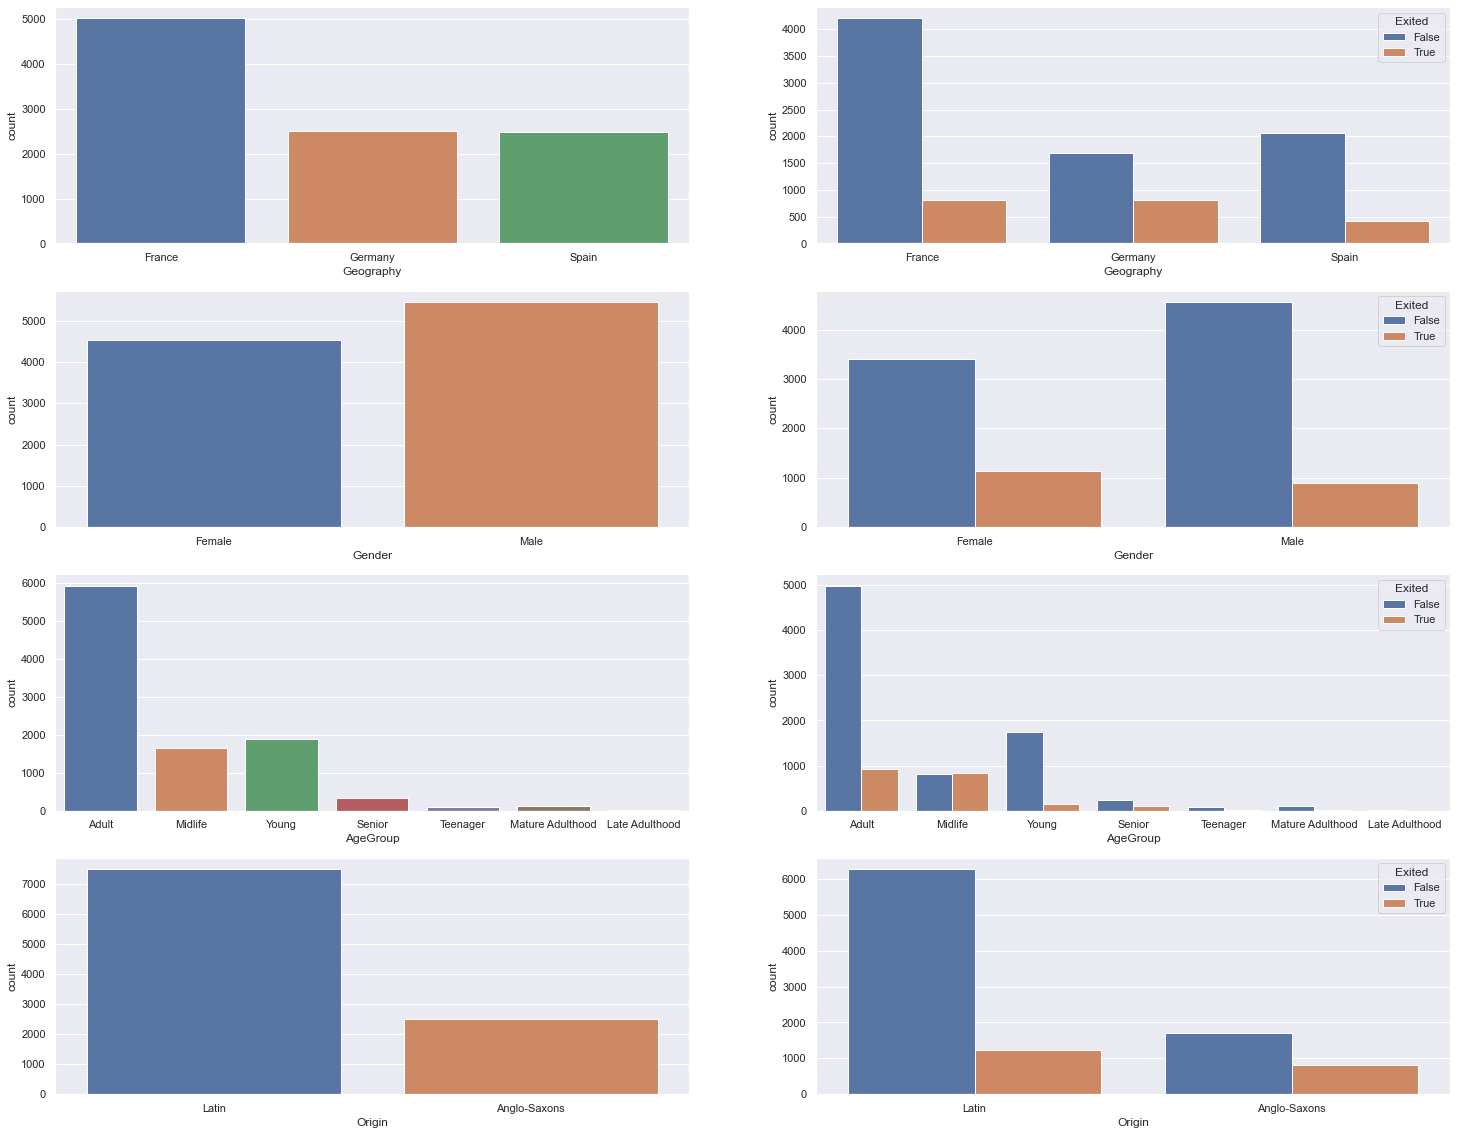

In [18]:
count = 1
attributesToInspect = ['Geography', 'Gender', 'AgeGroup', 'Origin']
rows= len(attributesToInspect)
plt.figure(figsize=(25,5*rows))
for i in attributesToInspect:
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, data=df04)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, hue='Exited', data=df04)
    count += 1
plt.show()

In [19]:
dfBool = pd.DataFrame(boolAttributes.apply(lambda x: x.sum())).rename(columns={0:"Yes"})
dfBool['No'] = dfBool['Yes'].apply(lambda row: df04.shape[0] - row)
dfBool.head()

,Yes,No
HasCrCard,7055,2945
IsActiveMember,5151,4849
Exited,2037,7963


## Bivariate Analysis

### H01 - Men usually have more churn
---
> - Conclusion: **FALSE** 
>> **WOMEN** have more churn

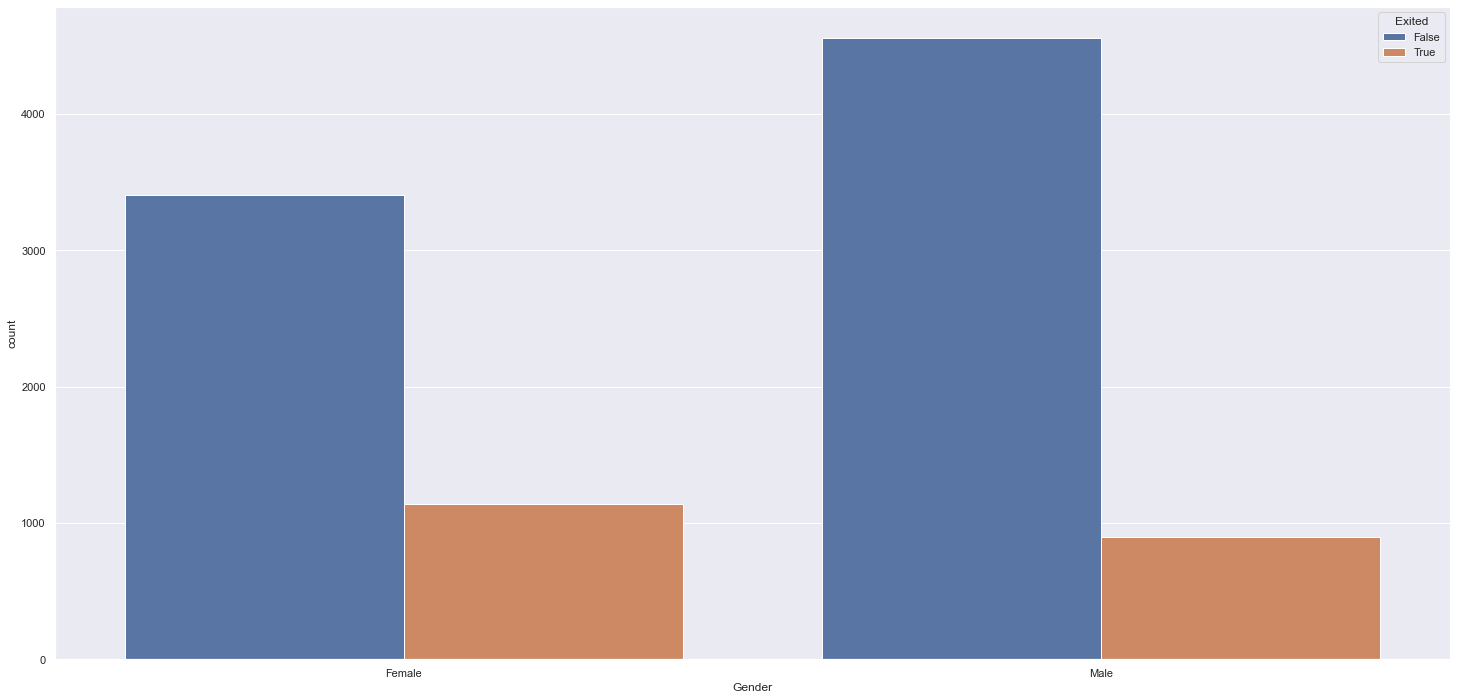

In [20]:
sns.countplot(x='Gender', hue='Exited', data=df04)
plt.show()

### H02 - Women usually buy more products
---
> - Conclusion: **FALSE** 
>> **MEN** usually buy more products

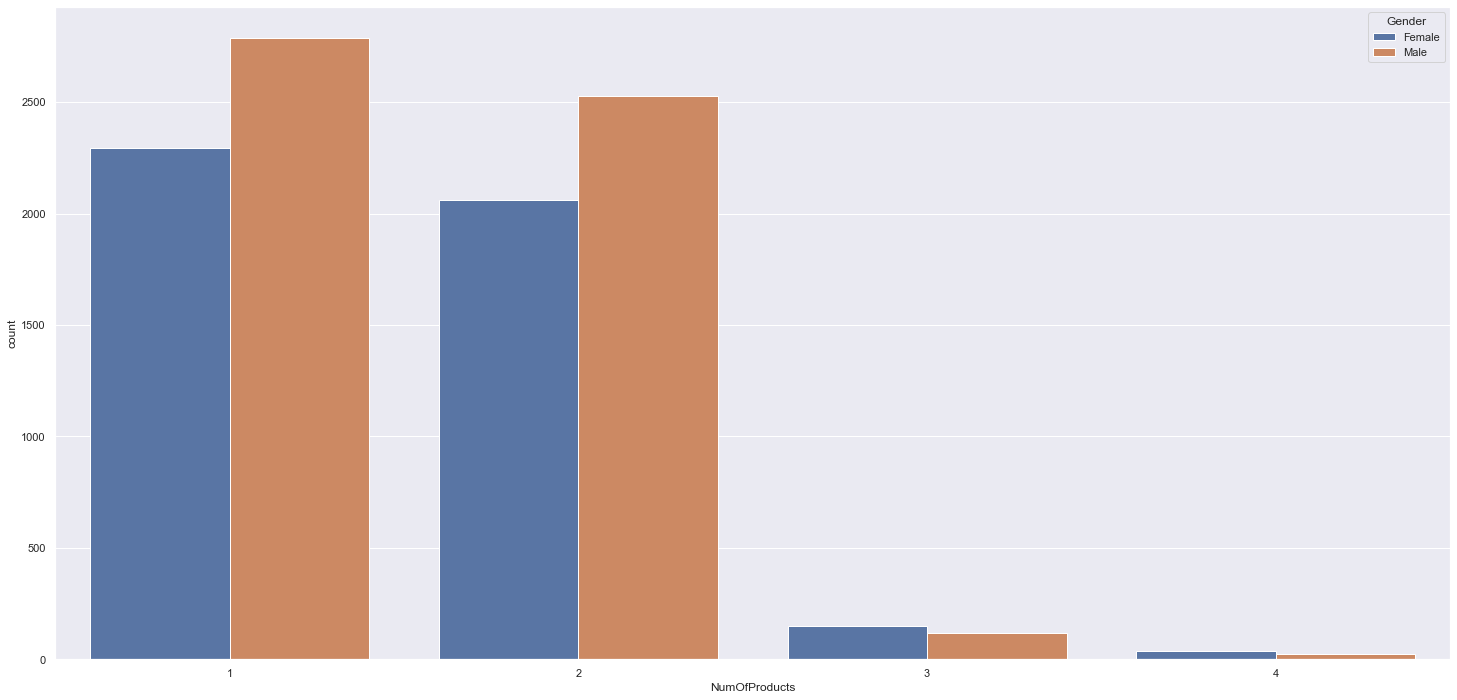

In [21]:
sns.countplot(x='NumOfProducts', hue='Gender', data=df04);

### H03 - Younger clients are less loyal and more likely to leave a bank
---
> - Conclusion: **FALSE** 
>> Younger clients are **MORE** loyal and more likely to leave a bank

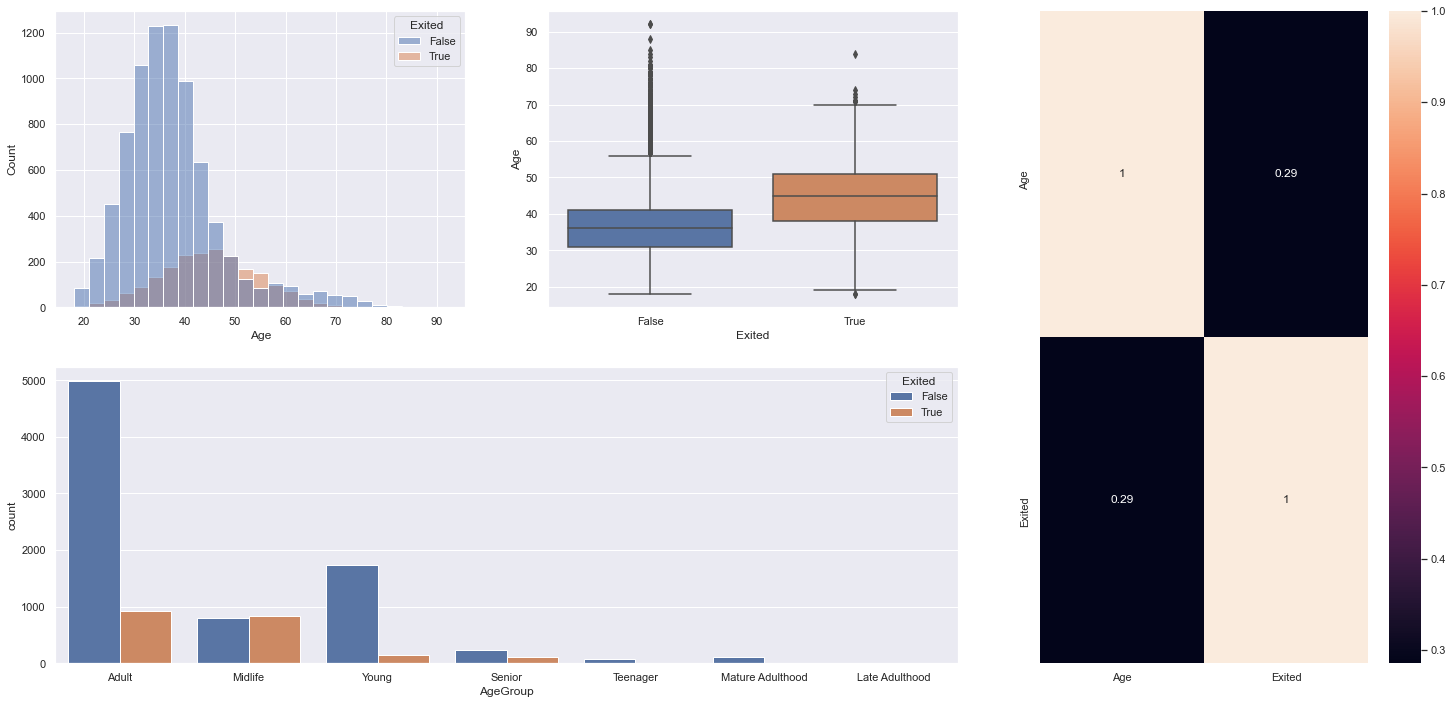

In [23]:
aux01 = df04[['Age', 'AgeGroup', 'Exited']]

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
sns.histplot(x='Age', bins=25, hue='Exited', data=aux01);

plt.subplot(grid[0,1])
sns.boxplot(x='Exited', y='Age', data=aux01);

plt.subplot(grid[1,:2])
sns.countplot(x='AgeGroup', hue='Exited', data=aux01);

plt.subplot(grid[:,2])
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H04 - Clients with higher estimated wages have higher Churn Rate
---
> - Conclusion: **INCONCLUSIVE** 
>> Clients with higher estimated wages have **almost the same** Churn Rate

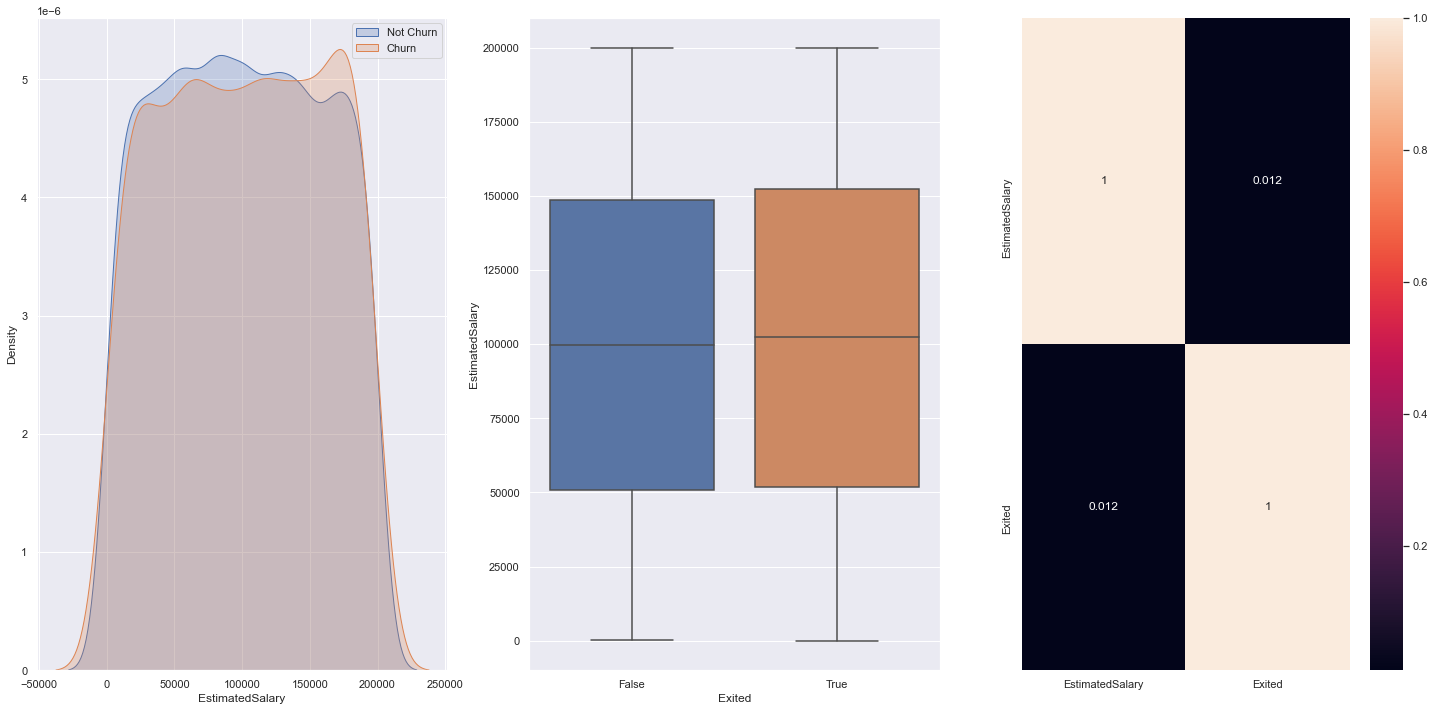

In [24]:
aux01 = df04[['EstimatedSalary', 'Exited']]

plt.subplot(1,3,1)
sns.kdeplot(aux01[aux01['Exited'] == False]['EstimatedSalary'], label='Not Churn', shade=True);
sns.kdeplot(aux01[aux01['Exited'] == True]['EstimatedSalary'], label='Churn', shade=True);
plt.legend()

plt.subplot(1,3,2)
sns.boxplot(x="Exited", y="EstimatedSalary", data=aux01);

plt.subplot(1,3,3)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H05 - Countries of Latin origin have higher number of churn
---
> - Conclusion: **FALSE** 
>> Countries of **Anglo-Saxons** origin have higher number of churn

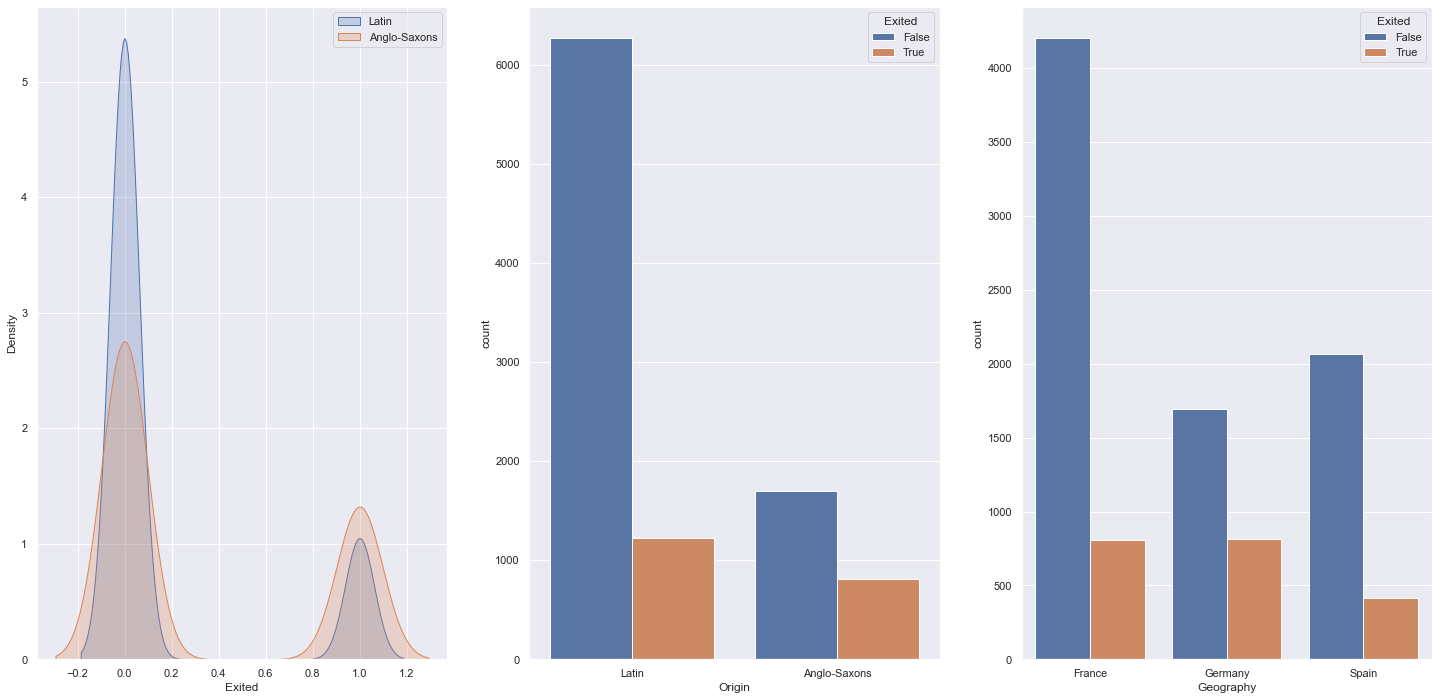

In [25]:
aux01 = df04[['Origin', 'Exited']]

plt.subplot(1,3,1)
sns.kdeplot(aux01[aux01['Origin'] == 'Latin']['Exited'], label='Latin', shade=True);
sns.kdeplot(aux01[aux01['Origin'] == 'Anglo-Saxons']['Exited'], label='Anglo-Saxons', shade=True);
plt.legend()

plt.subplot(1,3,2)
sns.countplot(x='Origin', hue='Exited', data=aux01);

plt.subplot(1,3,3)
sns.countplot(x='Geography', hue='Exited', data=df04);

### H06 - Active members have less churn
---
> - Conclusion: **TRUE** 
>> Active members have less churn

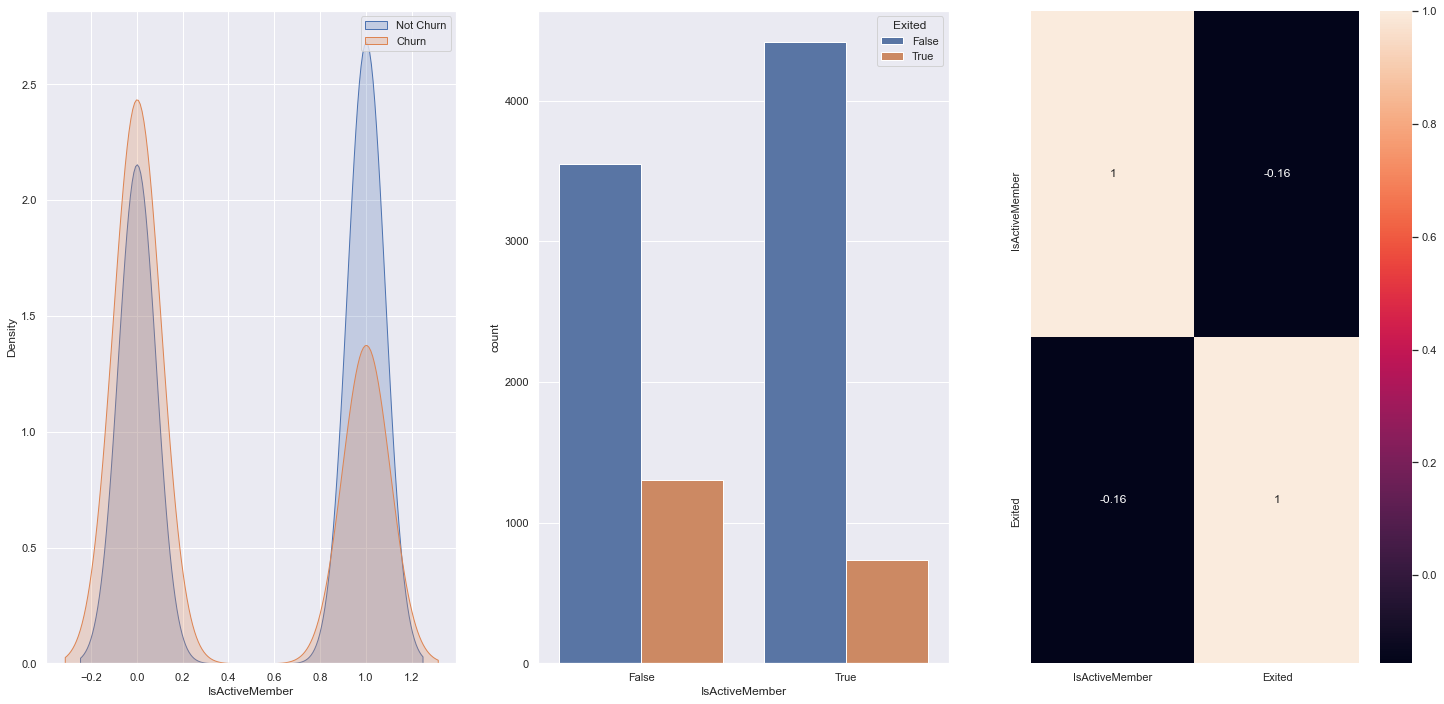

In [26]:
aux01 = df04[['IsActiveMember', 'Exited']]

plt.subplot(1,3,1)
sns.kdeplot(aux01[aux01['Exited'] == False]['IsActiveMember'], label='Not Churn', shade=True);
sns.kdeplot(aux01[aux01['Exited'] == True]['IsActiveMember'], label='Churn', shade=True);
plt.legend()

plt.subplot(1,3,2)
sns.countplot(x='IsActiveMember', hue='Exited', data=df04);

plt.subplot(1,3,3)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H07 - Along the years Churn tends to be lower
---
> - Conclusion: **FALSE** 
>> Along the years Churn does not reduce

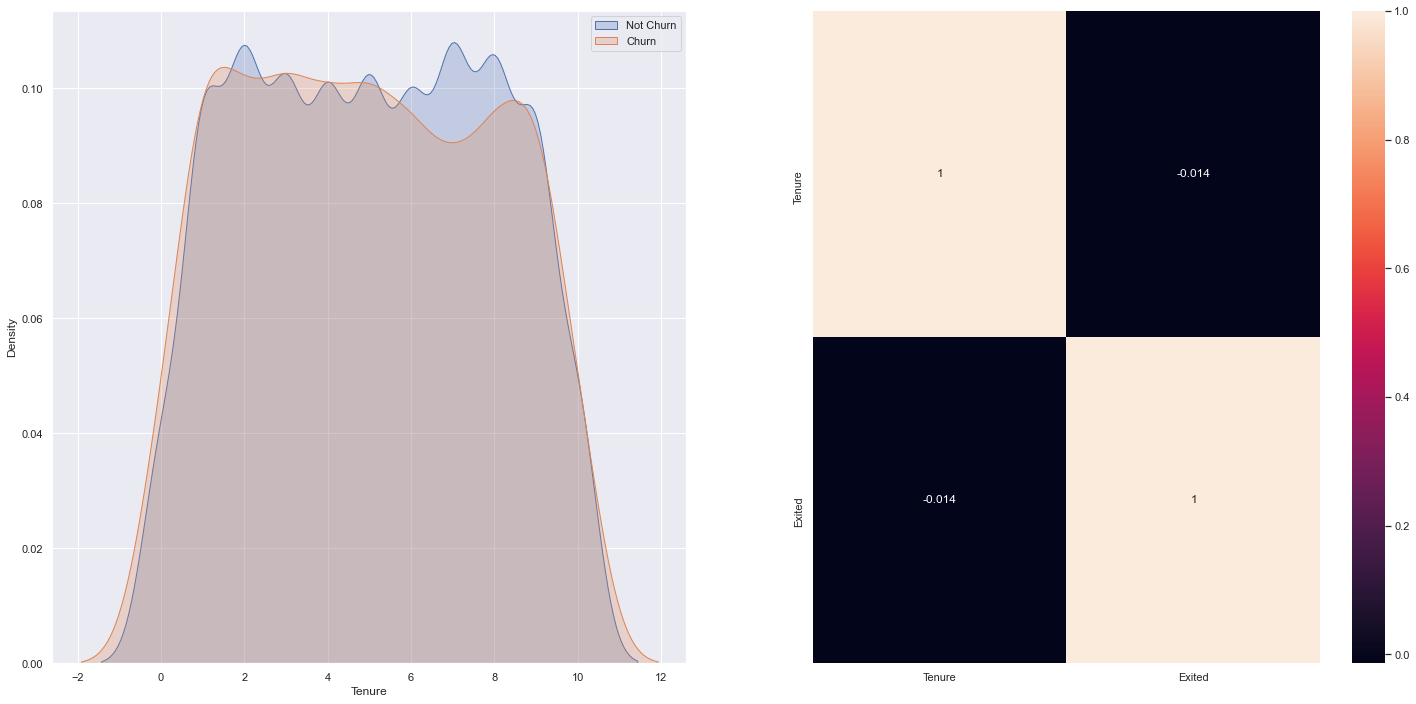

In [27]:
aux01 = df04[['Tenure', 'Exited']]

plt.subplot(1,2,1)
sns.kdeplot(aux01[aux01['Exited'] == False]['Tenure'], label='Not Churn', shade=True);
sns.kdeplot(aux01[aux01['Exited'] == True]['Tenure'], label='Churn', shade=True);
plt.legend()

plt.subplot(1,2,2)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H08 - Customers with Credit Cards tend to stay at the bank
---
> - Conclusion: **FALSE** 
>> Customers with Credit Cards have a churn rate similar to customers without credit cards

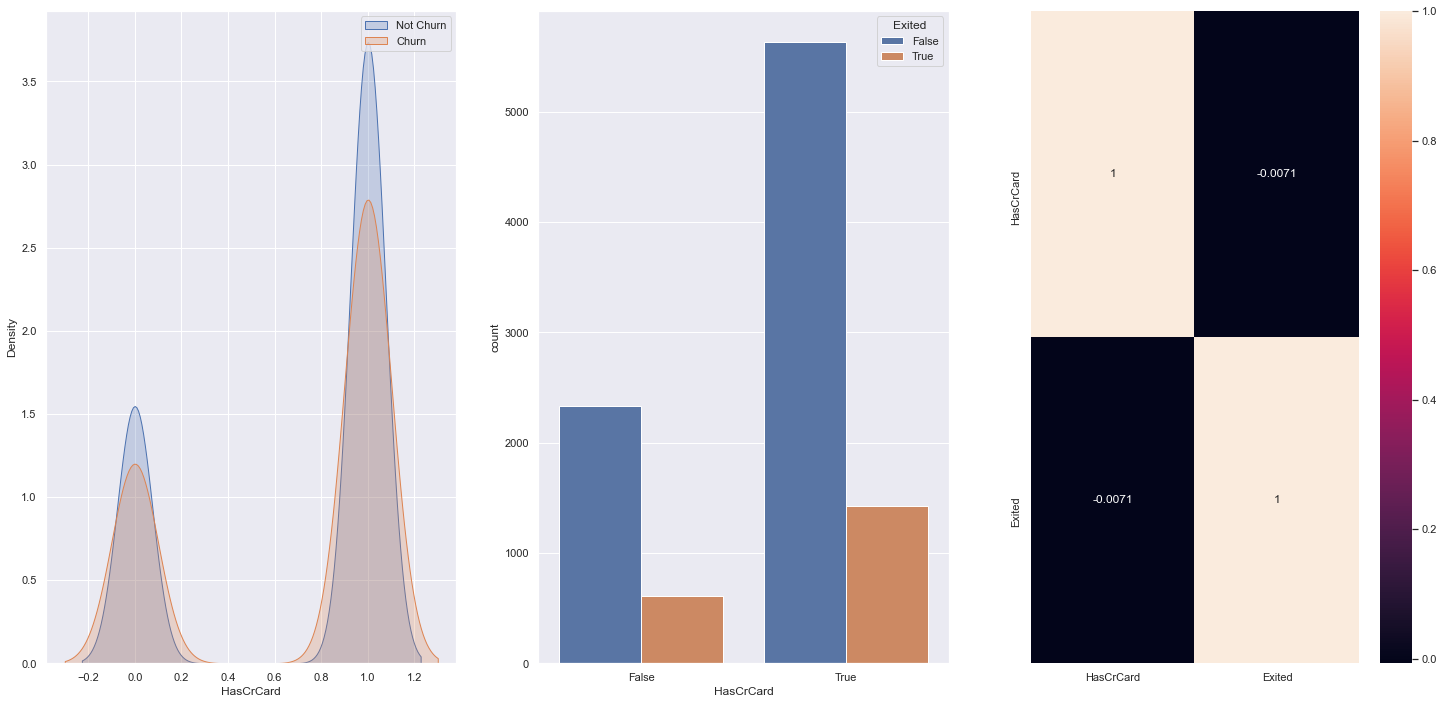

In [28]:
aux01 = df04[['HasCrCard', 'Exited']]

plt.subplot(1,3,1)
sns.kdeplot(aux01[aux01['Exited'] == False]['HasCrCard'], label='Not Churn', shade=True);
sns.kdeplot(aux01[aux01['Exited'] == True]['HasCrCard'], label='Churn', shade=True);
plt.legend()

plt.subplot(1,3,2)
sns.countplot(x='HasCrCard', hue='Exited', data=aux01);

plt.subplot(1,3,3)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H09 - Customers with higher balance remain at the bank
---
> - Conclusion: **Trur** 
>> Customers with higher balance remain at the bank

No handles with labels found to put in legend.


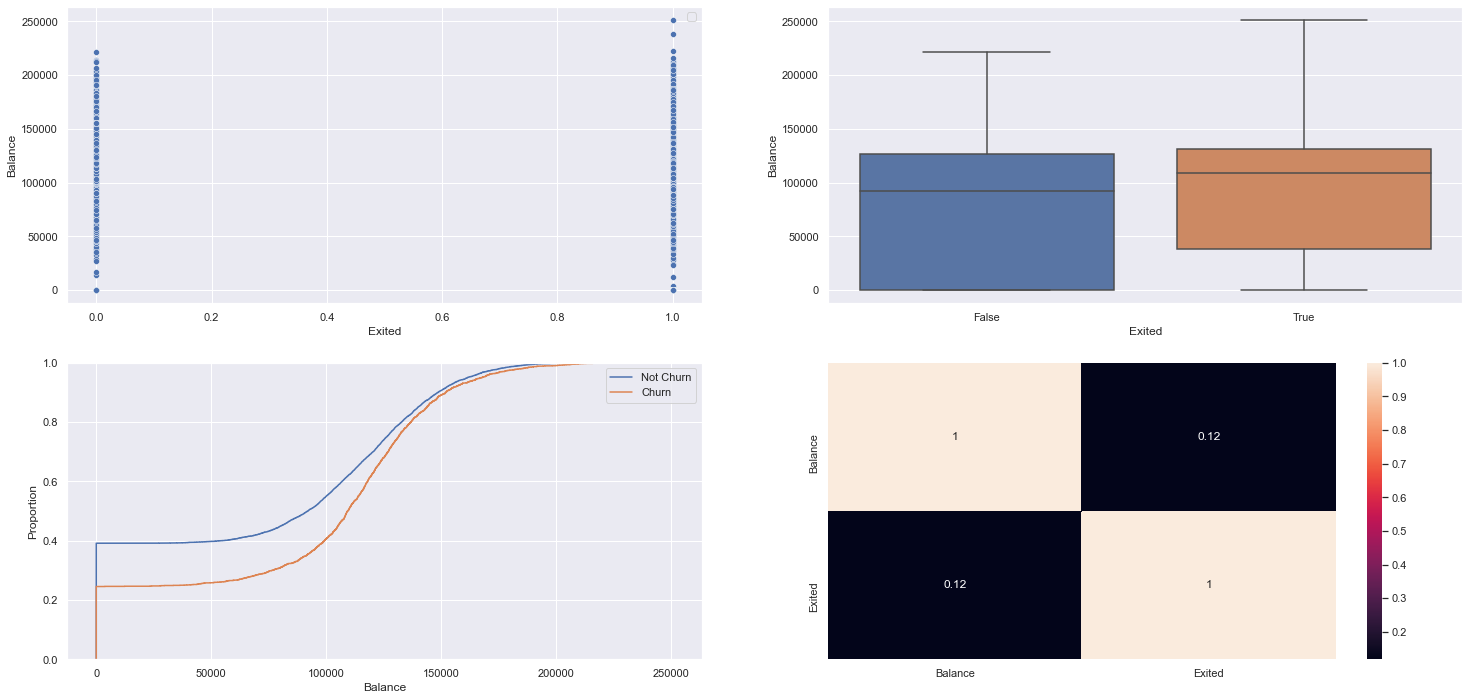

In [29]:
aux01 = df04[['Balance', 'Exited']]

plt.subplot(2,2,1)
sns.scatterplot(y='Balance', x='Exited', data=aux01);
plt.legend()

plt.subplot(2,2,2)
sns.boxplot(y='Balance', x='Exited', data=aux01);

plt.subplot(2,2,3)
sns.ecdfplot(data=aux01[aux01['Exited'] == False], x="Balance", label='Not Churn');
sns.ecdfplot(data=aux01[aux01['Exited'] == True], x="Balance", label='Churn');
plt.legend()

plt.subplot(2,2,4)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

## Multivariate Analysis

### Numerical and Boolean Attributes

In [30]:
# Numerical Attributes and Boolean
numAttributesAndBool = df04.select_dtypes(include=['int64', 'float64', 'bool'])
NotNumerial = ['RowNumber', 'CustomerId']
numAttributesAndBool = numAttributesAndBool[numAttributesAndBool.columns[~numAttributesAndBool.columns.isin(NotNumerial)]]

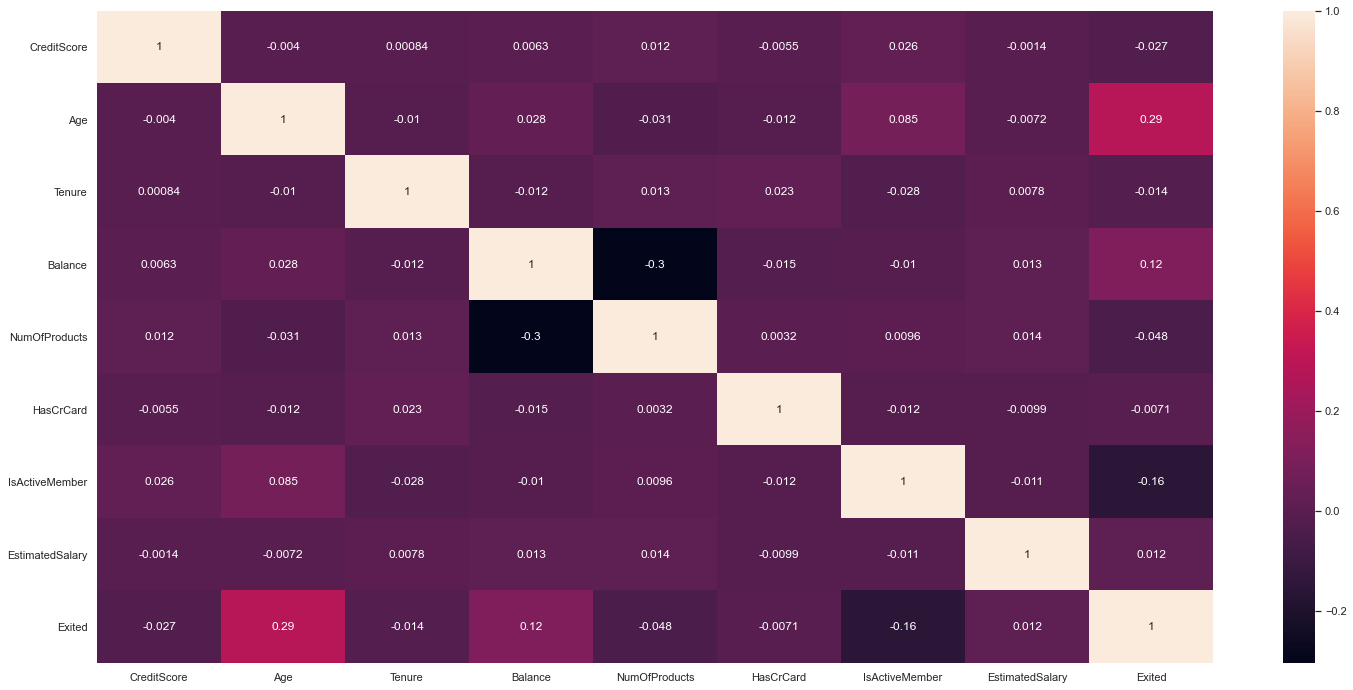

In [31]:
correlation = numAttributesAndBool.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### Categorical Attributes

In [32]:
#Categorical Attributes
catAttributes = df04.select_dtypes(include=['category'])

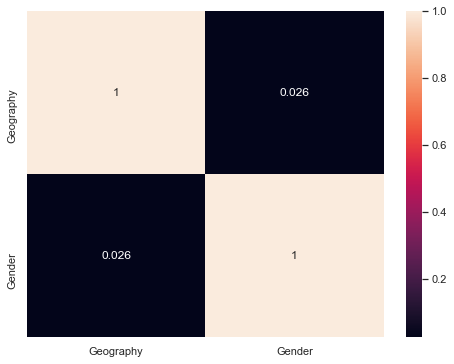

In [33]:
a1 = cramerV(catAttributes['Geography'], catAttributes['Geography'])
a2 = cramerV(catAttributes['Geography'], catAttributes['Gender'])

a3 = cramerV(catAttributes['Gender'], catAttributes['Geography'])
a4 = cramerV(catAttributes['Gender'], catAttributes['Gender'])
	
#Final Dataset
dictCramerV = {
                'Geography':[a1, a2],
                'Gender':[a3, a4]
                }

d = pd.DataFrame(dictCramerV)

d = d.set_index(d.columns)

#HeatMap Plot
plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True)
plt.show()

# Convert to .feather

In [34]:
df03.to_feather('00-Data/FeatherData/df04.feather')